# Lab4. Train your Tensorflow script on SageMaker

In this lab, you will run your training job with SageMaker. You will use your CNN architecture and script that you build at Lab3. 

 ## Set up SageMaker environment

* **Plase note that the Tensorflow eager mode will be enabled by below code:**  
 tf.enable_eager_execution()

In [1]:
from PIL import Image
import json
import os
import matplotlib.image as mpimg
import tensorflow as tf
# import pipeline
# import charset
# import model_fn
# import filters
from tensorflow.contrib.eager.python import tfe
from sagemaker.tensorflow import TensorFlow

tf.enable_eager_execution()

In [2]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::308961792850:role/service-role/AmazonSageMaker-ExecutionRole-20180531T094549
CPU times: user 126 ms, sys: 8.91 ms, total: 135 ms
Wall time: 166 ms


## Upload data to S3

* **Make sure you change the bucket name None with your S3 bucket name**


In [3]:
bucket = None #'leonkang-datalake-nv' # custom bucket name.
prefix = 'anpr'
assert bucket != None

* Upload files to S3
* It may take several minutes **(4~5 minutes for 5,000 images)**

In [5]:
%%time

train_channel = prefix + '/tf/tf-train'
validation_channel = prefix + '/tf/tf-validation'
train_annotation_channel = prefix + '/tf/tf-train_annotation'
validation_annotation_channel = prefix + '/tf/tf-validation_annotation'

sess.upload_data(path='tf/tf-train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='tf/tf-validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='tf/tf-train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='tf/tf-validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 58.1 s, sys: 3.83 s, total: 1min 1s
Wall time: 7min 19s


* Check upload results 

In [6]:
!aws s3 ls {bucket}/anpr/od/od-train/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-train_annotation/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-validation/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-validation_annotation/ |wc -l

4000
4000
1000
1000


In [8]:
s3_output_location = 's3://{}/{}/tf-output'.format(bucket, prefix)

## Run training job on SageMaker

Training data will be copied from S3 to Tensorflow container.  
Refer to the below directory paths.

### Test and validation data directories
1) In this notebook
- train images: './tf/tf-train'
- train annotations: './tf/tf-train_annotations'
- validation images: './tf/tf-validation'
- validation annotations: './tf/tf-validation_annotations'

2) S3
- train images: 's3://leonkang-datalake-seoul/anpr/tf/tf-train'
- train annotations: 's3://leonkang-datalake-seoul/anpr/tf/tf-validation'
- validation images: 's3://leonkang-datalake-seoul/anpr/tf/tf-train_annotations'
- validation annotations: 's3://leonkang-datalake-seoul/anpr/tf/tf-validation_annotations'

**3) Training container (Tensorflow container)**
- **train images: '/opt/ml/input/data/train/'**
- **train annotations: '/opt/ml/input/data/train_annotation/'**
- **validation images: '/opt/ml/input/data/validation/'**
- **validation annotations: '/opt/ml/input/data/validation_annotation/'**

In [16]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/png', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/png', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

* **This time, we will run 30 epochs to build more accurate model. (It may take less than 10 minutes)**
* Note that we will use p3.16xlarge instance, which will shorten our training time
* Refer to API specs of SDK site
    * https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/README.rst
    * https://sagemaker.readthedocs.io/en/latest/using_tf.html
* Refer to the API document 
    * https://sagemaker.readthedocs.io/en/stable/sagemaker.tensorflow.html  
   (Note that checkpoint_path, training_steps, evaluation_steps, requirements_file args are not permitted when using Script Mode)

In [110]:
model_dir = '/opt/ml/model'
train_instance_type='ml.p3.16xlarge'
hyperparameters = {'epochs': 30, 
                   'batch_size': 128,
                   'learning_rate': 0.001}

In [111]:
%%time
ocr_estimator = TensorFlow(entry_point='cnn_ocr.py',
                             role=role,
                             model_dir=model_dir,
                             hyperparameters=hyperparameters,
                             train_instance_count=2,
                             train_instance_type=train_instance_type,
                             distributions={'parameter_server': {'enabled': True}},
#                              distributions={
#                                   'mpi': {
#                                       'enabled': True,
#                                       'processes_per_host': 8,
#                                       'custom_mpi_options': '--NCCL_DEBUG INFO'
#                                   }
#                              }),
                             framework_version='1.12', 
                             py_version='py3')

ocr_estimator.fit(data_channels)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-308961792850
INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-scriptmode-2019-03-08-18-20-08-035


2019-03-08 18:20:08 Starting - Starting the training job...
2019-03-08 18:20:12 Starting - Launching requested ML instances.........
2019-03-08 18:21:47 Starting - Preparing the instances for training......
2019-03-08 18:22:50 Downloading - Downloading input data......
2019-03-08 18:24:06 Training - Downloading the training image..
2019-03-08 18:24:12,548 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-03-08 18:24:12,631 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2019-03-08 18:24:12,632 sagemaker_tensorflow_container.training INFO     Launching parameter server process
2019-03-08 18:24:12,632 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2019-03-08 18:24:13,254 sagemaker_tensorflow_container.training INFO     Launching worker process
2019-03-08 18:24:13,758 sagemaker-containers INFO     Invoking user script

Training Env:

* Check the model name that training job just created
* Check the model file that training job just created

In [112]:
print(ocr_estimator.output_path)
print(ocr_estimator.model_data)

!aws s3 ls {ocr_estimator.model_data}

s3://sagemaker-us-east-1-308961792850/
s3://sagemaker-us-east-1-308961792850/sagemaker-tensorflow-scriptmode-2019-03-08-18-20-08-035/output/model.tar.gz
2019-03-08 18:27:04   75779829 model.tar.gz


## Test data

In [33]:
import numpy as np

In [31]:
NUMS =['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
CHARS=['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '고', '노', '도', '로', '모', '구', '누', '두', '루', '무', 
       '버', '서', '어', '저', '처', '커', '터', '퍼', '보', '소', '오', '조', '초', '코', '토', '포', '부', '수', '우', '주', '추', '쿠', '투', '푸', '후', 
       '그', '느', '드', '르', '므', '브', '스', '으', '즈', '츠', '크', '트', '프', '흐',
       '바', '사', '아', '자', '차', '카', '타', '파', '하', '허', '호']
SPACE=[' ']
JOIN =NUMS + CHARS + SPACE
n_chr = len(JOIN)

In [108]:
test_imgs = os.listdir('tf/tf-validation')
# threshold = 0.4
# test_img = Image.open('tf/tf-validation/' + test_imgs[0])

In [109]:
# test_img_np = np.array(test_img.resize((128,64)))
# test_img_np.shape

## Test the trainned model in local

* Copy trainned model from S3 to ./model folder

In [114]:
#!rm -Rf model
!aws s3 cp {ocr_estimator.model_data} ./model/model.tar.gz --region us-east-1

download: s3://sagemaker-us-east-1-308961792850/sagemaker-tensorflow-scriptmode-2019-03-08-18-20-08-035/output/model.tar.gz to model/model.tar.gz


* Extract the model file and see the components

In [115]:
!tar -xvzf ./model/model.tar.gz -C ./model

weights.ckpt.index
checkpoint
1552069606/
1552069606/saved_model.pb
1552069606/variables/
1552069606/variables/variables.data-00000-of-00001
1552069606/variables/checkpoint
1552069606/variables/variables.index
1552069606/assets/
1552069606/assets/saved_model.json
weights.ckpt.data-00000-of-00001
1552069609/
1552069609/variables/
1552069609/variables/checkpoint
1552069609/variables/variables.data-00000-of-00001
1552069609/variables/variables.index
1552069609/assets/
1552069609/assets/saved_model.json
1552069609/saved_model.pb
checkpoint
weights.ckpt.index
weights.ckpt.data-00000-of-00001


* Define model architecture locally (same as Lab3)

In [122]:
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = tf.keras.layers.ZeroPadding2D((2, 2))(X_input)

    # CONV0 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(48, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool0')(X)

    # CONV1 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((1, 2), strides = (2, 2), name='max_pool1')(X)

    # CONV2 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn2')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool2')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = tf.keras.layers.Flatten()(X)
#     X = tf.keras.layers.Dense(7, activation='softmax', name='fc')(X)

    #----------------------------------------------------------
    d1 = tf.keras.layers.Dense(81, activation='softmax', name='d1')(X)
    d2 = tf.keras.layers.Dense(81, activation='softmax', name='d2')(X)
    d3 = tf.keras.layers.Dense(81, activation='softmax', name='d3')(X)
    d4 = tf.keras.layers.Dense(81, activation='softmax', name='d4')(X)
    d5 = tf.keras.layers.Dense(81, activation='softmax', name='d5')(X)
    d6 = tf.keras.layers.Dense(81, activation='softmax', name='d6')(X)
    d7 = tf.keras.layers.Dense(81, activation='softmax', name='d7')(X)
    
    model = tf.keras.Model(inputs = X_input, 
                  outputs = [d1,d2,d3,d4,d5,d6,d7],
                  name='CNN_ANPR')

    return model

* Read and retore model from downloaded checkpoint

In [123]:
tf.keras.backend.clear_session()
device = '/cpu:0' 

with tf.device(device):    
    local_model = model((128,64,1))
    saver = tfe.Saver(local_model.variables)
    saver.restore('model/weights.ckpt')

INFO:tensorflow:Restoring parameters from model/weights.ckpt


INFO:tensorflow:Restoring parameters from model/weights.ckpt


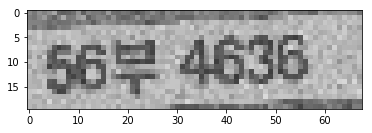

0
['5', '8', '무', '4', '5', '3', '6']


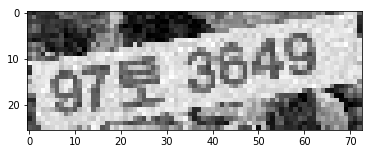

1
['2', '7', '로', '3', '6', '1', '4']


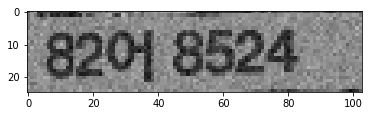

2
['3', '2', '어', '8', '2', '2', '4']


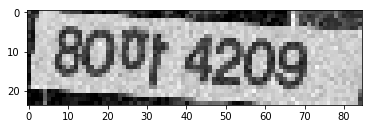

3
['9', '0', '하', '6', '2', '0', '9']


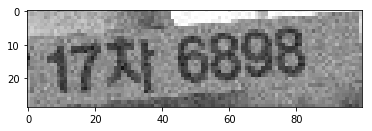

4
['1', '7', '바', '6', '8', '4', '8']


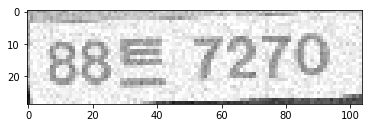

5
['3', '8', '로', '7', '2', '7', '0']


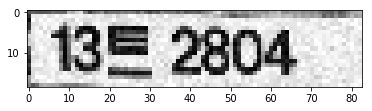

6
['1', '1', '트', '3', '0', '9', '4']


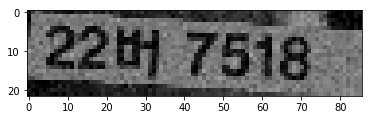

7
['2', '2', '버', '7', '5', '4', '8']


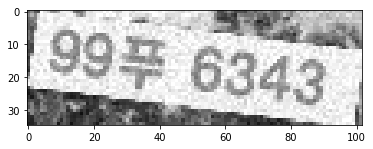

8
['9', '9', '푸', '6', '3', '4', '3']


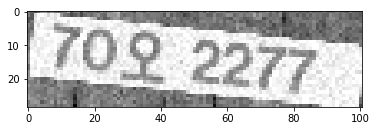

9
['7', '0', '오', '2', '2', '7', '1']


In [125]:
for i in range(10):
    val_img = Image.open('tf/tf-validation/' + test_imgs[i])
    val_img_np = np.array(val_img.resize((128,64)))
    prediction = local_model.predict(val_img_np.reshape([1,128,64,1])/255.)
    plt.imshow(val_img)
    plt.show()
    print(i)
    digits = [JOIN[np.argmax(prediction[0][0])], 
              JOIN[np.argmax(prediction[1][0])], 
              JOIN[np.argmax(prediction[2][0])], 
              JOIN[np.argmax(prediction[3][0])], 
              JOIN[np.argmax(prediction[4][0])], 
              JOIN[np.argmax(prediction[5][0])], 
              JOIN[np.argmax(prediction[6][0])]]
    print(digits)

## Deploy the model and inference Test

In [74]:
predictor = ocr_estimator.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge',
                                 accelerator_type='ml.eia1.medium')

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-scriptmode-2019-03-08-17-34-51-290
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-scriptmode-2019-03-08-17-34-51-290


---------------------------------------------------------------!

In [126]:
predictor.endpoint

'sagemaker-tensorflow-scriptmode-2019-03-08-17-34-51-290'

In [ ]:
# aws 예제 : https://github.com/aws-samples/amazon-sagemaker-script-mode/blob/master/tf-eager-script-mode/tf-eager-sm-scriptmode.ipynb
results = predictor.predict(x_test[:10])['predictions'] 
flat_list = [float('%.1f'%(item)) for sublist in results for item in sublist]
print('predictions: \t{}'.format(np.array(flat_list)))
print('target values: \t{}'.format(y_test[:10].round(decimals=1)))


In [136]:
val_img_np.shape

(64, 128)

In [ ]:
sess.sagemaker_runtime_client.invoke_endpoint

In [ ]:
X_input

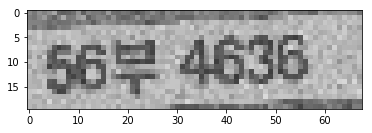

0
['6', '3', '무', '4', '6', '3', '8']


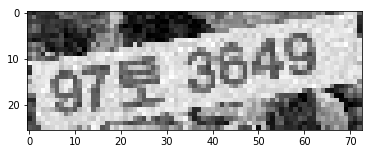

1
['9', '7', '트', '3', '6', '3', '8']


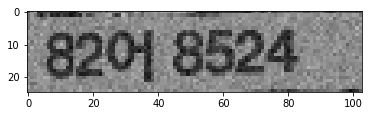

2
['1', '2', '아', '8', '8', '2', '4']


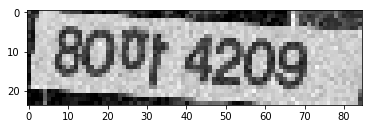

3
['9', '0', '하', '4', '8', '0', '8']


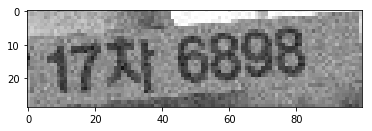

4
['1', '7', '어', '6', '8', '8', '8']


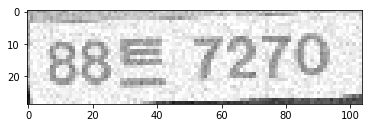

5
['3', '3', '트', '7', '0', '7', '7']


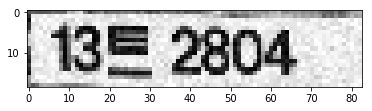

6
['1', '3', '로', '3', '0', '9', '6']


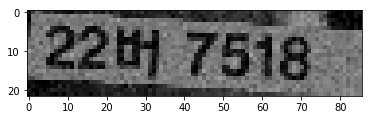

7
['2', '2', '버', '7', '5', '4', '8']


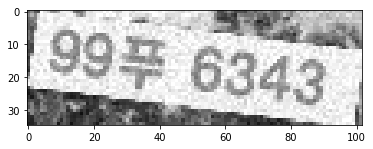

8
['9', '0', '초', '4', '3', '4', '3']


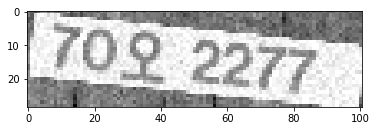

9
['7', '0', '오', '2', '2', '7', '7']


In [151]:
for i in range(10):
    val_img = Image.open('tf/tf-validation/' + test_imgs[i])
    val_img_np = np.array(val_img.resize((128,64)))
    input = {
      'instances': val_img_np.reshape([1,128,64,1])/255.
    }
    prediction = predictor.predict(input)
    plt.imshow(val_img)
    plt.show()
    print(i)
    digits = [JOIN[np.argmax(prediction['predictions'][0]['d1'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d2'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d3'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d4'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d5'])],  
              JOIN[np.argmax(prediction['predictions'][0]['d6'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d7'])]]
    print(digits)

In [65]:
test_imgs[0]
#predictor.predict()

'00004479_89_8910_0.png'

In [80]:
bbb

array([[255, 236, 252, ..., 207, 202, 164],
       [255, 236, 252, ..., 207, 202, 164],
       [142, 146, 149, ..., 226, 220, 193],
       ...,
       [141,  56,  78, ...,  58,  47,  61],
       [ 83,  81,  62, ...,  47,  38,  40],
       [ 83,  81,  62, ...,  47,  38,  40]], dtype=uint8)

In [42]:
import boto3
runtime = boto3.Session().client('runtime.sagemaker')

In [84]:
body=[bbb.reshape([1,128,64,1])/255.]
body

[array([[[[1.        ],
          [0.9254902 ],
          [0.98823529],
          ...,
          [0.84705882],
          [0.87843137],
          [0.84705882]],
 
         [[0.84705882],
          [0.84313725],
          [0.82745098],
          ...,
          [0.81176471],
          [0.79215686],
          [0.64313725]],
 
         [[1.        ],
          [0.9254902 ],
          [0.98823529],
          ...,
          [0.84705882],
          [0.87843137],
          [0.84705882]],
 
         ...,
 
         [[0.57254902],
          [0.70980392],
          [0.36862745],
          ...,
          [0.18431373],
          [0.14901961],
          [0.15686275]],
 
         [[0.3254902 ],
          [0.31764706],
          [0.24313725],
          ...,
          [0.39215686],
          [0.39607843],
          [0.57254902]],
 
         [[0.57254902],
          [0.70980392],
          [0.36862745],
          ...,
          [0.18431373],
          [0.14901961],
          [0.15686275]]]])]

In [83]:
tf_endpoint = 'sagemaker-tensorflow-scriptmode-2019-03-03-14-29-58-825'
response = runtime.invoke_endpoint(EndpointName=tf_endpoint,
                                   ContentType='image/png',
                                   Body=body)
response['Body']

ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value: [array([[[[1.        ],
         [0.9254902 ],
         [0.98823529],
         ...,
         [0.84705882],
         [0.87843137],
         [0.84705882]],

        [[0.84705882],
         [0.84313725],
         [0.82745098],
         ...,
         [0.81176471],
         [0.79215686],
         [0.64313725]],

        [[1.        ],
         [0.9254902 ],
         [0.98823529],
         ...,
         [0.84705882],
         [0.87843137],
         [0.84705882]],

        ...,

        [[0.57254902],
         [0.70980392],
         [0.36862745],
         ...,
         [0.18431373],
         [0.14901961],
         [0.15686275]],

        [[0.3254902 ],
         [0.31764706],
         [0.24313725],
         ...,
         [0.39215686],
         [0.39607843],
         [0.57254902]],

        [[0.57254902],
         [0.70980392],
         [0.36862745],
         ...,
         [0.18431373],
         [0.14901961],
         [0.15686275]]]])], type: <class 'list'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

In [107]:
tf_endpoint = 'sagemaker-tensorflow-scriptmode-2019-03-03-14-29-58-825'
response = runtime.invoke_endpoint(EndpointName=tf_endpoint,
                                   ContentType='application/x-image',
                                   Body=b)
response['Body']

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (415) from model with message "{"error": "Unsupported Media Type: application/x-image"}". See https://ap-northeast-2.console.aws.amazon.com/cloudwatch/home?region=ap-northeast-2#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-tensorflow-scriptmode-2019-03-03-14-29-58-825 in account 308961792850 for more information.

In [ ]:
temp = response['Body'].read()

In [93]:
sess.sagemaker_client.list_endpoints()

{'Endpoints': [{'EndpointName': 'tf-eager-scriptmode-bostonhousing-2019-03-08-12-11-37-519',
   'EndpointArn': 'arn:aws:sagemaker:ap-northeast-2:308961792850:endpoint/tf-eager-scriptmode-bostonhousing-2019-03-08-12-11-37-519',
   'CreationTime': datetime.datetime(2019, 3, 8, 12, 22, 54, 133000, tzinfo=tzlocal()),
   'LastModifiedTime': datetime.datetime(2019, 3, 8, 12, 22, 54, 133000, tzinfo=tzlocal()),
   'EndpointStatus': 'Creating'},
  {'EndpointName': 'sagemaker-tensorflow-scriptmode-2019-03-03-14-29-58-825',
   'EndpointArn': 'arn:aws:sagemaker:ap-northeast-2:308961792850:endpoint/sagemaker-tensorflow-scriptmode-2019-03-03-14-29-58-825',
   'CreationTime': datetime.datetime(2019, 3, 3, 14, 41, 45, 507000, tzinfo=tzlocal()),
   'LastModifiedTime': datetime.datetime(2019, 3, 3, 14, 47, 4, 51000, tzinfo=tzlocal()),
   'EndpointStatus': 'InService'},
  {'EndpointName': 'object-detection-2019-03-03-10-28-15-473',
   'EndpointArn': 'arn:aws:sagemaker:ap-northeast-2:308961792850:endpoint

In [101]:
predictor=sagemaker.predictor.RealTimePredictor(tf_endpoint, sagemaker_session=sess, content_type='application/octet-stream')

In [102]:
predictor

In [96]:
import numpy as np
def get_imgs_data(train_dir):
    ck_imgs = os.listdir(train_dir)
    flg_first = True
    for i in ck_imgs:
        ext = i.split('.')[1]
        if ext == 'png':
#             print(train_dir + i)
            img=Image.open(train_dir + i) 
            img = img.resize((128, 64))
            imgs = img if flg_first else np.append(imgs, img)
            flg_first = False
    return imgs.reshape([-1, 128, 64, 1])/255.
imgs = get_imgs_data('tsf-validation/')

FileNotFoundError: [Errno 2] No such file or directory: 'tsf-validation/'

In [104]:
# results = predictor.predict(imgs[:1])['predictions'] 
b = bytearray(bbb)
results = predictor.predict(b)['predictions'] 
# flat_list = [float('%.1f'%(item)) for sublist in results for item in sublist]
# print('predictions: \t{}'.format(np.array(flat_list)))
# print('target values: \t{}'.format(y_test[:10].round(decimals=1)))
Y = results[0]
print(np.argmax(Y['d1']))

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (415) from model with message "{"error": "Unsupported Media Type: application/octet-stream"}". See https://ap-northeast-2.console.aws.amazon.com/cloudwatch/home?region=ap-northeast-2#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-tensorflow-scriptmode-2019-03-03-14-29-58-825 in account 308961792850 for more information.